# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

Ideas:
- Parallelize the code.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [874]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev



In [830]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c

In [919]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    rolling_ols_window = 100
    exp_rolling_ols_lambda=0.01

In [832]:
# Helper functions
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
performance_record_mse = {}
performance_record_wacc = {}

def create_random_sensitivity(timespan):
    num_points = int(np.round(np.random.rand()*8) + 2)
    smoothing_parameter = np.exp(2*np.random.rand() - 1.5)
    x = np.floor(np.random.rand(num_points)*timespan)
    x = np.append(x, [0, timespan-1])
    x.sort()
    y = 2*np.random.rand(num_points + 2) - 1

    spleen = splrep(x, y, s=smoothing_parameter)
    values = splev(factors.index, spleen)
    sensitivity = pd.Series(data=values, index=factors.index)
    sensitivity[sensitivity < -5] = -5
    sensitivity[sensitivity > 5] = 5
    return sensitivity

def plot_estimated_sensitivities(sens, est_sens, colors):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    axc = ax[0,0]
    axc.plot(est_sens.iloc[:,0], c=colors[0])
    axc.plot(sens.iloc[:,0], '--', c='k')
    axc = ax[0,1]
    axc.plot(est_sens.iloc[:,1], c=colors[1])
    axc.plot(sens.iloc[:,1], '--', c='k')
    axc = ax[1,0]
    axc.plot(est_sens.iloc[:,2], c=colors[2])
    axc.plot(sens.iloc[:,2], '--', c='k')
    
def compute_estimated_returns(factors, est_sens):
    return pd.Series(np.multiply(factors, est_sens.shift()).sum(axis=1))

def plot_residuals(estimated_returns, returns):
    residuals = estimated_returns - returns
    plt.scatter(residuals.index, residuals, s=0.5)
    
def print_mse_performance(estimated_returns, returns, name, performance_record_mse, verbose=True):
    square_errors = np.square(estimated_returns - returns)
    mean_square_error = square_errors.sum()/len(estimated_returns)
    performance_record_mse[name] = mean_square_error
    if verbose:
        print(f"MSE for {name}, assuming the factors known: {mean_square_error}")
    
def print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc, verbose=True):
    weights = abs(returns)
    correct_sign = -2*np.logical_xor(estimated_returns > 0, returns > 0) + 1
    weighted_accuracy = np.multiply(weights, correct_sign).mean()
    performance_record_wacc[name] = weighted_accuracy
    if verbose:
        print(f"Weighted accuracy for {name}, assuming the factors known: {weighted_accuracy}")
    
def plot_prediction_performance(factors, returns, est_sens, name):
    estimated_returns = compute_estimated_returns(factors, est_sens)
    print_mse_performance(estimated_returns, returns, name, performance_record_mse)
    print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc)
    plot_residuals(estimated_returns, returns)
    

In [833]:
# Sensitivities
timespan = 10000

def get_sensitivities(timespan, sens_type):
    pi = 3.1415
    if sens_type == "Various smooth":
        t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
        sens1 = -(pd.Series(np.arctan((t-timespan/2)/timespan*100)) - pi/2)/pi
        sens2 = (pd.Series(np.sin(t/timespan*3.2 - 1.5)) + 1)/2
        sens3 = pd.Series(np.sin(t/timespan*5) + np.sin(t/timespan*10 + 150) + \
                          np.sin(t/timespan*20 + 150))/2
    elif sens_type == "Random walk":
        sens1 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 + 1
        sens2 = pd.Series(np.random.normal(size=timespan)).cumsum()/200
        sens3 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 - 1
    elif sens_type == "Random smooth":
        sens1 = create_random_sensitivity(timespan)
        sens2 = create_random_sensitivity(timespan)
        sens3 = create_random_sensitivity(timespan)

    return pd.concat([sens1, sens2, sens3], axis=1)

sens = get_sensitivities(timespan, sens_type)

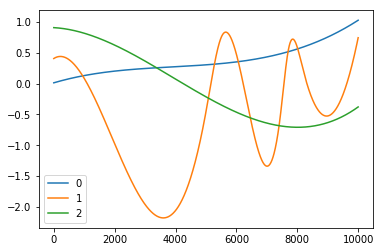

In [834]:
sens.plot()

In [835]:
# Factors
def get_factors(timespan):
    
    factor1 = pd.Series(np.random.normal(size=timespan))
    factor2 = pd.Series(np.random.normal(size=timespan))
    factor3 = pd.Series(np.random.normal(size=timespan))
    return pd.concat([factor1, factor2, factor3], axis=1)

factors = get_factors(timespan)

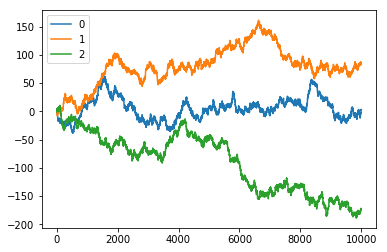

In [836]:
factors.cumsum(axis=0).plot()

In [837]:
# Returns
def get_returns(timespan, factors, sens, error_std):
    error = np.random.normal(size=timespan)*error_std
    return pd.Series(np.multiply(factors, sens).sum(axis=1) + error)

returns = get_returns(timespan, factors, sens, 1.0)

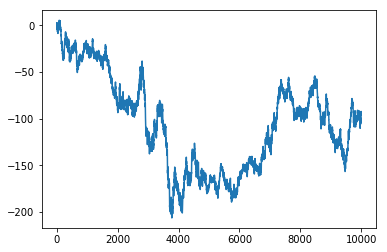

In [838]:
returns.cumsum().plot()

## Constant regression

In [839]:
def estimate_sensitivities_cr(factors, returns):
    reg = linear_model.LinearRegression()
    reg.fit(factors, returns)
    return pd.DataFrame(data = [reg.coef_], index = factors.index)

In [840]:
estimated_sensitivities_cr = estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,0.372622,-0.570819,-0.077863
1,0.372622,-0.570819,-0.077863
2,0.372622,-0.570819,-0.077863
3,0.372622,-0.570819,-0.077863
4,0.372622,-0.570819,-0.077863
5,0.372622,-0.570819,-0.077863
6,0.372622,-0.570819,-0.077863
7,0.372622,-0.570819,-0.077863
8,0.372622,-0.570819,-0.077863
9,0.372622,-0.570819,-0.077863


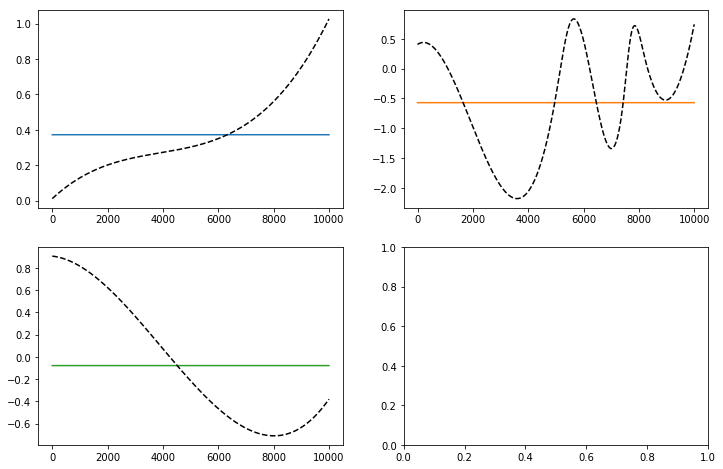

In [841]:
plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 2.1856666625260353
Weighted accuracy for Constant OLS, assuming the factors known: 0.5565533105911789


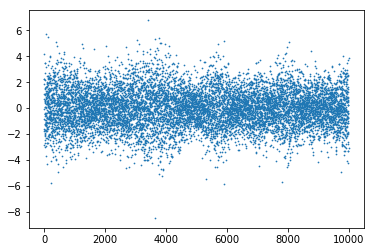

In [842]:
plot_prediction_performance(factors, 
                            returns, 
                            estimated_sensitivities_cr, 
                            "Constant OLS")

## Rolling regression

In [843]:
def estimate_sensitivities_rr(factors, returns, window):
    model = PandasRollingOLS(y=returns, x=factors, window=window)
    return pd.DataFrame(model.beta)

In [844]:
window = rolling_ols_window
estimated_sensitivities_rr = estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
199,0.081420,0.536664,0.851829
200,0.087434,0.524956,0.845257
201,0.074053,0.528848,0.832714
202,0.078004,0.512134,0.850663
203,0.076133,0.514436,0.845781
204,0.078587,0.485671,0.853403
205,0.079920,0.479277,0.856627
206,0.073968,0.481022,0.853484
207,0.072174,0.482028,0.850234
208,0.076582,0.480866,0.850871


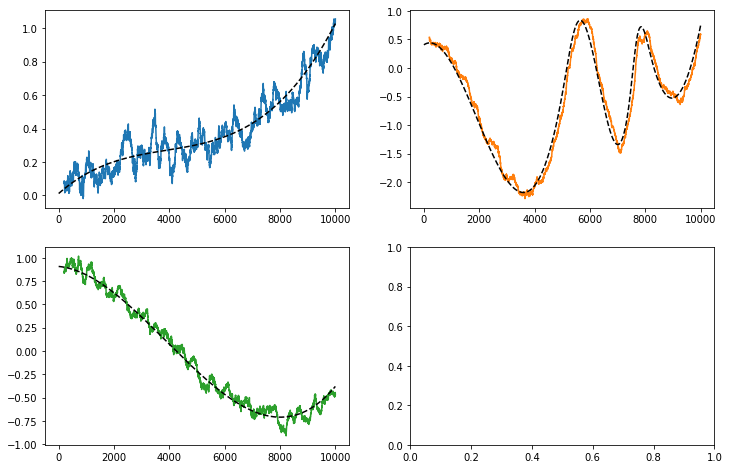

In [845]:
plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 1.0227608444295488
Weighted accuracy for Rolling OLS, assuming the factors known: 0.9588485040967144


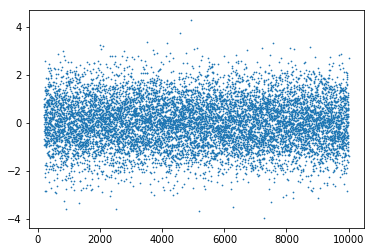

In [846]:
plot_prediction_performance(factors.iloc[window-1:,:], 
                            returns.iloc[window-1:], 
                            estimated_sensitivities_rr, 
                            "Rolling OLS")

## Weighted rolling regression

In [847]:
# How to do that efficiently??

In [848]:
def estimate_sensitivities_err(factors, returns, lambd):
    ff = np.zeros([3,3])
    fr = np.zeros(3)
    est_sens_list = []
    for i, row in factors.iterrows():
        ff = (1-lambd)*ff + lambd*np.outer(row, row)
        fr = (1-lambd)*fr + lambd*np.dot(row, returns.iloc[i])
        est_sens = np.dot(np.linalg.inv(ff + 1e-9*np.eye(3)), fr)
        est_sens_list.append(est_sens)
    return pd.DataFrame(est_sens_list)  

In [849]:
estimated_sensitivities_err = estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

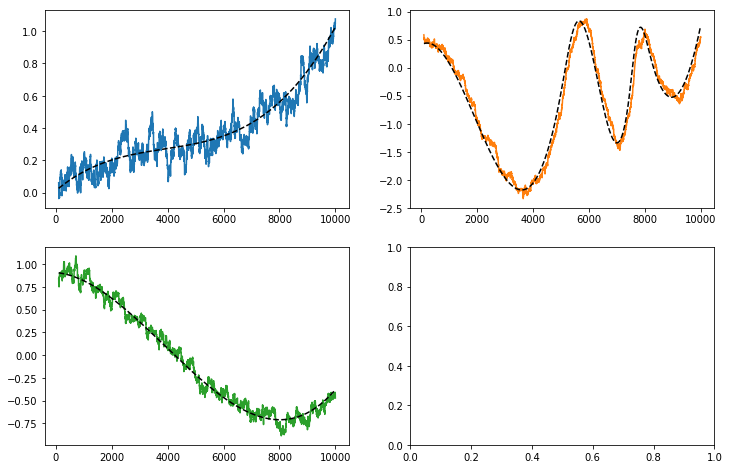

In [850]:
plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 1.0202433923161314
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 0.9653213051995856


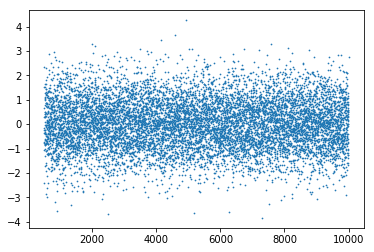

In [851]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_err.iloc[burn_period:,:], 
                            "Exponential rolling OLS")

## Kalman filter

In [852]:
def estimate_sensitivities_kf(factors, returns, covariance_ratio):
    n_dim_state=3
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = np.eye(3)*covariance_ratio
    observation_matrices = factors.values[:,np.newaxis,:]
    kf = KalmanFilter(initial_state_mean=[0,0,0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means)

In [853]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,-0.411649,0.845757,0.633560
1,0.213462,0.645991,1.302478
2,0.757316,1.121110,0.774108
3,0.617943,1.103306,0.846863
4,0.683059,1.260837,0.834768
5,0.695617,1.285274,0.830243
6,0.698878,1.285906,0.829705
7,0.699574,1.295717,0.850488
8,0.553635,1.264881,0.887199
9,0.639631,1.327779,0.856383


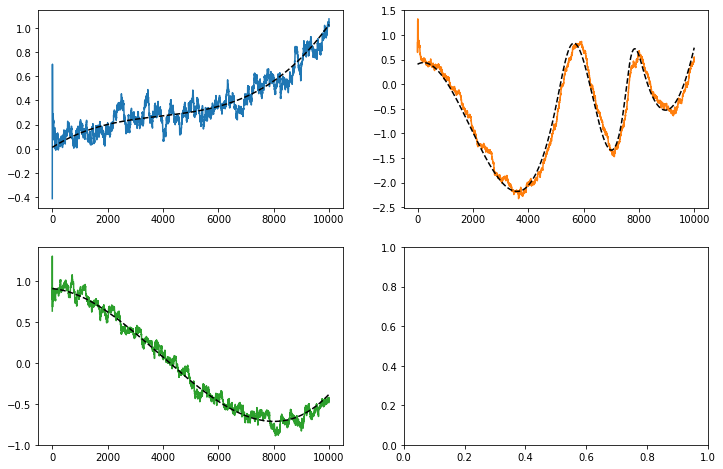

In [854]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 1.0210836635528961
Weighted accuracy for Kalman, assuming the factors known: 0.9654247050091546


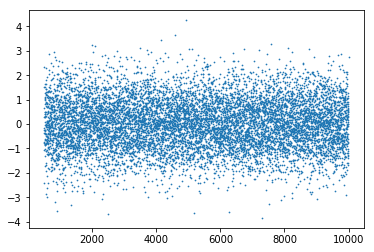

In [855]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_kf.iloc[burn_period:,:], 
                            "Kalman")

In [856]:
def estimate_sensitivities_ntc(estimated_sensitivities, trend_factor, window):
    rolling_mean = estimated_sensitivities.rolling(window, axis=0).mean()
    return (1 + trend_factor)*pd.DataFrame(estimated_sensitivities) - trend_factor*rolling_mean

In [857]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc
#rolling_mean = pd.DataFrame(filtered_state_means).rolling(100, axis=0).mean()
#trend_est_sens = (1 + trend_factor)*pd.DataFrame(filtered_state_means) - trend_factor*rolling_mean

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


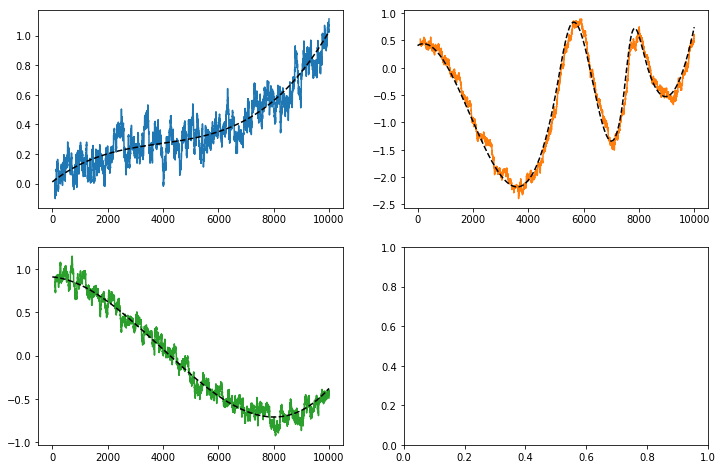

In [858]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 1.0180497309670016
Weighted accuracy for Kalman naive trend, assuming the factors known: 0.9662758899493278


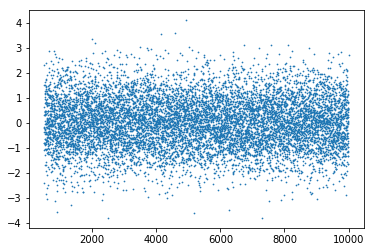

In [859]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], estimated_sensitivities_kf_ntc.iloc[burn_period:,:], "Kalman naive trend")

## Stochastic trend Kalman filter

In [860]:
def estimate_sensitivities_stkf(factors, returns, covariance_ratio):
    n_dim_state=6
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = covariance_ratio*np.eye(6)
    observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                     factors.values[:, 1], 0*factors.values[:, 1],
                                     factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
    transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
    kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance,
                      transition_matrices=transition_matrix
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means[:,[0,2,4]])

In [861]:
estimated_sensitivities_stkf = estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

,0,1,2
0,-0.411649,0.845757,0.633560
1,0.244413,0.633145,1.331156
2,1.489774,0.738453,0.525185
3,0.910585,2.456235,0.754259
4,0.374257,1.224856,0.418737
5,0.356565,1.301810,0.278071
6,0.738603,1.465566,0.271918
7,0.855969,1.682002,0.810778
8,0.238023,1.670884,0.934111
9,0.391729,2.063730,0.779920


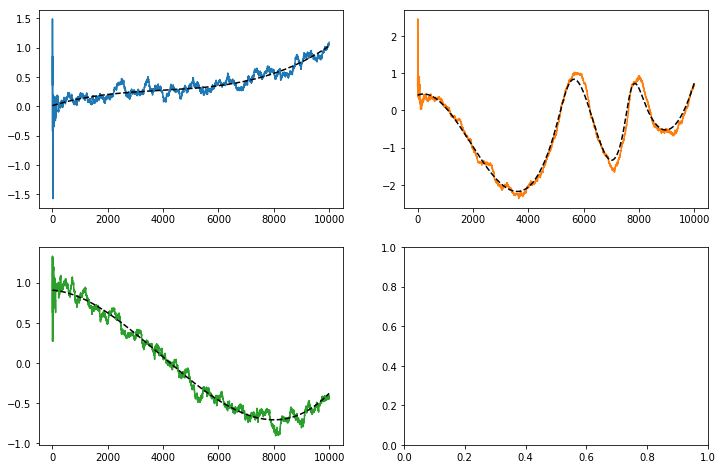

In [862]:
plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

MSE for Kalman stoch trend, assuming the factors known: 1.015231785683694
Weighted accuracy for Kalman stoch trend, assuming the factors known: 0.9714879422800135


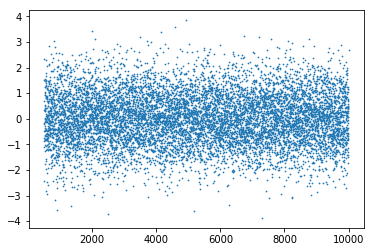

In [863]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_stkf.iloc[burn_period:,:], 
                            "Kalman stoch trend")

## Performance summary

In [864]:
pd.Series(performance_record_mse).sort_values()

Kalman stoch trend         1.015232
Kalman naive trend         1.018050
Exponential rolling OLS    1.020243
Kalman                     1.021084
Rolling OLS                1.022761
Constant OLS               2.185667
dtype: float64

In [865]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

Kalman stoch trend         0.971488
Kalman naive trend         0.966276
Kalman                     0.965425
Exponential rolling OLS    0.965321
Rolling OLS                0.958849
Constant OLS               0.556553
dtype: float64

## Optimisation of the hyperparameters

In [932]:
def estimate_regression_performance(factors, returns, name, performance_record_mse, 
                                    performance_record_wacc, **kwargs):
    burn_period = 500
    if name[:12] == "Constant OLS":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_cr(factors, returns)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:11] == "Rolling OLS":
        start_time = burn_period
        rolling_ols_window = kwargs['rolling_ols_window']
        estimated_sensitivities = estimate_sensitivities_rr(factors, returns, rolling_ols_window)
        estimated_sensitivities = estimated_sensitivities.iloc[burn_period - rolling_ols_window + 1:,:]
    elif name[:23] == "Exponential rolling OLS":
        start_time = burn_period
        exp_rolling_ols_lambda = kwargs['exp_rolling_ols_lambda']
        estimated_sensitivities = estimate_sensitivities_err(factors, returns, 
                                                             exp_rolling_ols_lambda)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:18] == "Kalman naive trend":
        start_time = burn_period
        kalman_covariance_ratio = kwargs['kalman_covariance_ratio']
        nt_factor = kwargs['nt_factor']
        nt_window = kwargs['nt_window']
        estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, 
                                                               kalman_covariance_ratio)
        estimated_sensitivities = estimate_sensitivities_ntc(estimated_sensitivities_kf, 
                                                             nt_factor, nt_window)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:18] == "Kalman stoch trend":
        start_time = burn_period
        stkf_covariance_ratio = kwargs['stkf_covariance_ratio']
        estimated_sensitivities = estimate_sensitivities_brtkf(factors, returns, stkf_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:6] == "Kalman":
        start_time = burn_period
        kalman_covariance_ratio = kwargs['kalman_covariance_ratio']
        estimated_sensitivities = estimate_sensitivities_kf(factors, returns, kalman_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    else:
        print("Unknown name")
    estimated_returns = compute_estimated_returns(factors.iloc[start_time:,:], estimated_sensitivities)
    print_mse_performance(estimated_returns, 
                          returns.iloc[start_time:], 
                          name, 
                          performance_record_mse,
                          verbose=False)
    print_weighted_accuracy_performance(estimated_returns, 
                                        returns.iloc[start_time:], 
                                        name, 
                                        performance_record_wacc,
                                        verbose=False)    

    
def compare_hyperparameters(algo_name, num_samples, **kwargs):
    """
    The keyword arguments passed should correspond to the parameters of the algorithms and consists of lists of values to 
    try (a grid search).
    """
    parameter_list = []
    value_list = []
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for parameter, par_value_list in kwargs.items():
        parameter_list.append(parameter)
        value_list.append(par_value_list)
    print
    all_values = list(itertools.product(*value_list))
    
    for i in range(len(all_values)):
        all_values[i] = dict(zip(parameter_list, all_values[i]))
    
    for i in range(num_samples):
        print(i)
        
        # Sensitivities
        if sens_type in ["Random walk", "Random smooth"]:
            sens = get_sensitivities(timespan, sens_type)
        # Factors
        factors = get_factors(timespan)
        # Returns
        returns = get_returns(timespan, factors, sens, 1.0)
        
        for kwargs in all_values:
            name = algo_name + ' - ' + str(kwargs)
            estimate_regression_performance(factors, returns, name, performance_record_mse, performance_record_wacc, **kwargs)
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
    
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

def print_t_stat(performance, reference=None):
    if reference is None:
        ref_value = performance.iloc[:,0].mean()
    else:
        ref_value = performance.loc[reference].mean()
        
    print((performance.mean() - ref_value).divide(performance.std()/np.sqrt(len(performance))))

### Rolling OLS

In [915]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Rolling OLS", 
                                                                          1000, 
                                                                          rolling_ols_window=[50, 100, 200, 300])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [916]:
performance_record_wacc.describe()

,Rolling OLS - {'rolling_ols_window': 100},Rolling OLS - {'rolling_ols_window': 200},Rolling OLS - {'rolling_ols_window': 300},Rolling OLS - {'rolling_ols_window': 50}
count,300.000000,300.000000,300.000000,300.000000
mean,1.468523,1.465598,1.457630,1.461485
std,0.950490,0.943880,0.937267,0.955739
min,0.393934,0.408548,0.412567,0.378754
25%,0.787682,0.790886,0.783359,0.773707
50%,1.105177,1.105312,1.097937,1.098826
75%,1.991129,1.979281,1.967475,1.989152
max,4.614951,4.605605,4.598632,4.617141


In [917]:
print_t_stat(performance_record_wacc)

Rolling OLS - {'rolling_ols_window': 100}    0.000000
Rolling OLS - {'rolling_ols_window': 200}   -0.053672
Rolling OLS - {'rolling_ols_window': 300}   -0.201307
Rolling OLS - {'rolling_ols_window': 50}    -0.127538
dtype: float64


### Exponential rolling OLS

In [920]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Exponential rolling OLS", 
                                                                          1000, 
                                                                          exp_rolling_ols_lambda=[0.002, 0.005, 0.01, 0.02, 0.05])

0
1
2
3
4
5
6
7
8
9


In [921]:
performance_record_wacc.describe()

,Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.141785,1.185545,1.195216,1.193832,1.184951
std,0.591494,0.598382,0.602527,0.604527,0.608059
min,0.538764,0.555054,0.549366,0.540323,0.521589
25%,0.834404,0.861134,0.865160,0.862751,0.851152
50%,0.954191,1.012909,1.023583,1.025502,1.016686
75%,1.369601,1.413683,1.425921,1.428129,1.424790
max,2.518949,2.552165,2.562450,2.563207,2.560482


In [922]:
print_t_stat(performance_record_wacc)

Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002}    0.000000
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}    0.231261
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01}     0.280428
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02}     0.272262
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}     0.224493
dtype: float64


### Kalman

In [924]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman", 
                                                                          1000, 
                                                                          kalman_covariance_ratio=[2e-5, 5e-5, 1e-4, 2e-4, 5e-4])

0
1


C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:512: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


2
3
4
5
6
7
8
9


In [925]:
performance_record_wacc.describe()

,Kalman - {'kalman_covariance_ratio': 0.0001},Kalman - {'kalman_covariance_ratio': 0.0002},Kalman - {'kalman_covariance_ratio': 0.0005},Kalman - {'kalman_covariance_ratio': 2e-05},Kalman - {'kalman_covariance_ratio': 5e-05}
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.944753,0.945364,0.942725,0.931796,0.941705
std,0.255002,0.255323,0.257447,0.253713,0.254933
min,0.657445,0.652658,0.646135,0.654003,0.654102
25%,0.746685,0.750505,0.751050,0.728170,0.743009
50%,0.917219,0.919221,0.915268,0.907846,0.917513
75%,1.121810,1.121717,1.117538,1.116277,1.121903
max,1.379029,1.379496,1.384617,1.350381,1.368222


In [926]:
print_t_stat(performance_record_wacc)

Kalman - {'kalman_covariance_ratio': 0.0001}    0.000000
Kalman - {'kalman_covariance_ratio': 0.0002}    0.007569
Kalman - {'kalman_covariance_ratio': 0.0005}   -0.024907
Kalman - {'kalman_covariance_ratio': 2e-05}    -0.161486
Kalman - {'kalman_covariance_ratio': 5e-05}    -0.037804
dtype: float64


### Kalman naive trend

In [927]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman naive trend", 
                                                                          1000, 
                                                                          kalman_covariance_ratio=[2e-4],
                                                                          nt_factor=[.1, .2, .5, 1.0, 2.0], 
                                                                          nt_window=[100])

0
1
2
3
4
5
6
7
8
9


In [928]:
performance_record_wacc.describe()

,"Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}"
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.360500,1.360500,1.360500,1.360500,1.360500
std,0.807415,0.807415,0.807415,0.807415,0.807415
min,0.593365,0.593365,0.593365,0.593365,0.593365
25%,0.857859,0.857859,0.857859,0.857859,0.857859
50%,1.091388,1.091388,1.091388,1.091388,1.091388
75%,1.642574,1.642574,1.642574,1.642574,1.642574
max,3.105791,3.105791,3.105791,3.105791,3.105791


In [929]:
print_t_stat(performance_record_wacc)

Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}    0.0
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}    0.0
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}    0.0
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}    0.0
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}    0.0
dtype: float64


### Kalman stochastic trend

In [933]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman stoch trend", 
                                                                          1000, 
                                                                          stkf_covariance_ratio=[1e-9, 2e-9, 5e-9, 1e-8, ])

0
1
2
3
4
5
6
7
8
9


In [934]:
performance_record_wacc.describe()

,Kalman stoch trend - {'stkf_covariance_ratio': 1e-09},Kalman stoch trend - {'stkf_covariance_ratio': 2e-09},Kalman stoch trend - {'stkf_covariance_ratio': 2e-10},Kalman stoch trend - {'stkf_covariance_ratio': 5e-09},Kalman stoch trend - {'stkf_covariance_ratio': 5e-10}
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.869686,1.871174,1.858455,1.871999,1.865467
std,1.212103,1.214134,1.209309,1.215209,1.210787
min,0.513688,0.513744,0.512471,0.511945,0.512725
25%,0.937781,0.935881,0.933306,0.936778,0.936105
50%,1.492114,1.498590,1.458663,1.500304,1.480451
75%,2.497539,2.496526,2.498042,2.497331,2.498230
max,4.216303,4.223905,4.192103,4.227454,4.205965


In [935]:
print_t_stat(performance_record_wacc)

Kalman stoch trend - {'stkf_covariance_ratio': 1e-09}    0.000000
Kalman stoch trend - {'stkf_covariance_ratio': 2e-09}    0.003877
Kalman stoch trend - {'stkf_covariance_ratio': 2e-10}   -0.029367
Kalman stoch trend - {'stkf_covariance_ratio': 5e-09}    0.006019
Kalman stoch trend - {'stkf_covariance_ratio': 5e-10}   -0.011019
dtype: float64


## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [892]:
def get_performance_data(num_samples, timespan):
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for i in range(num_samples):
        print(i)
        
        # Sensitivities
        if sens_type in ["Random walk", "Random smooth"]:
            sens = get_sensitivities(timespan, sens_type)
        # Factors
        factors = get_factors(timespan)
        # Returns
        returns = get_returns(timespan, factors, sens, 1.0)
                
        estimate_regression_performance(factors, returns, "Constant OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Rolling OLS", 
                                        performance_record_mse, performance_record_wacc, rolling_ols_window=rolling_ols_window)
        estimate_regression_performance(factors, returns, "Exponential rolling OLS", 
                                        performance_record_mse, performance_record_wacc, 
                                        exp_rolling_ols_lambda=exp_rolling_ols_lambda)
        estimate_regression_performance(factors, returns, "Kalman", 
                                        performance_record_mse, performance_record_wacc, 
                                        kalman_covariance_ratio=kalman_covariance_ratio)
        estimate_regression_performance(factors, returns, "Kalman naive trend", 
                                        performance_record_mse, performance_record_wacc, 
                                        kalman_covariance_ratio=kalman_covariance_ratio, 
                                        nt_factor=nt_factor, nt_window=nt_window)
        estimate_regression_performance(factors, returns, "Kalman stoch trend", 
                                        performance_record_mse, performance_record_wacc, 
                                        stkf_covariance_ratio=stkf_covariance_ratio)
        
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
        
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

In [872]:
num_samples = 10
performance_record_mse_new, performance_record_wacc_new = get_performance_data(num_samples, timespan)

0
1
2
3
4
5
6
7
8
9


In [380]:
performance_record_mse_rec = pd.concat([performance_record_mse, performance_record_mse_new], axis=0, ignore_index=True)
performance_record_wacc_rec = pd.concat([performance_record_wacc, performance_record_wacc_new], axis=0, ignore_index=True)

In [381]:
performance_record_mse = performance_record_mse_rec
performance_record_wacc = performance_record_wacc_rec

In [382]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1.665213,1.023461,1.023445,1.021889,1.027255,1.023878
std,0.024427,0.014725,0.014722,0.014762,0.014844,0.014767
min,1.582583,0.978147,0.978158,0.975813,0.981540,0.978675
25%,1.648875,1.013466,1.013437,1.011803,1.017113,1.013925
50%,1.665209,1.023639,1.023628,1.022029,1.027408,1.024081
75%,1.681885,1.033456,1.033504,1.031798,1.037234,1.034062
max,1.771593,1.083040,1.082747,1.082722,1.086006,1.083931


In [383]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.600322,0.867027,0.867029,0.868316,0.866385,0.866951
std,0.013888,0.012518,0.012505,0.012544,0.012562,0.012503
min,0.542035,0.811862,0.812441,0.811334,0.816825,0.813993
25%,0.590929,0.858763,0.858850,0.860031,0.858179,0.858820
50%,0.600565,0.866941,0.866945,0.868295,0.866336,0.866772
75%,0.609440,0.875114,0.875180,0.876517,0.874487,0.875158
max,0.651852,0.912957,0.913289,0.911171,0.910655,0.911652


In [384]:
performance_record_wacc.std()/np.sqrt(len(performance_record_wacc))

Constant OLS               0.000254
Exponential rolling OLS    0.000229
Kalman                     0.000228
Kalman Bentz trend         0.000229
Kalman naive trend         0.000229
Rolling OLS                0.000228
dtype: float64

In [385]:
(performance_record_wacc.mean() - performance_record_wacc['Rolling OLS'].mean()).divide(performance_record_wacc.std()/np.sqrt(len(performance_record_wacc)))

Constant OLS              -1051.578106
Exponential rolling OLS       0.332568
Kalman                        0.345567
Kalman Bentz trend            5.962067
Kalman naive trend           -2.467554
Rolling OLS                   0.000000
dtype: float64

In [386]:
(performance_record_mse.mean() - performance_record_mse['Rolling OLS'].mean()).divide(performance_record_mse.std()/np.sqrt(len(performance_record_mse)))

Constant OLS               1438.033011
Exponential rolling OLS      -1.553265
Kalman                       -1.612374
Kalman Bentz trend           -7.379752
Kalman naive trend           12.461025
Rolling OLS                   0.000000
dtype: float64

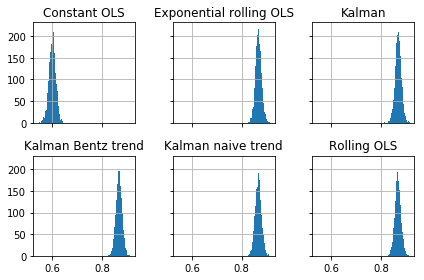

In [387]:
performance_record_wacc.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

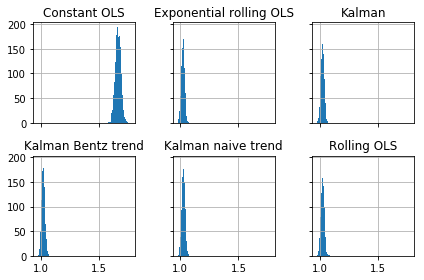

In [388]:
performance_record_mse.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

In [389]:
import pickle
with open('20190312-wERR-performance_record.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [1264]:
with open('performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
ls

{'MSE':       Constant OLS    Kalman  Kalman Bentz trend  Kalman naive trend  \
 0         1.642084  0.959128            0.969325            0.934450   
 1         1.652597  0.953329            0.964440            0.928491   
 2         1.672936  0.956445            0.966112            0.932220   
 3         1.673412  0.957570            0.967425            0.932708   
 4         1.673309  0.965016            0.974735            0.940621   
 5         1.683193  0.963870            0.972889            0.940625   
 6         1.654992  0.967241            0.977574            0.942468   
 7         1.658842  0.940273            0.949614            0.916005   
 8         1.660779  0.952864            0.963289            0.928959   
 9         1.661458  0.964175            0.974029            0.939953   
 10        1.666550  0.978255            0.987707            0.952743   
 11        1.682632  0.947483            0.958717            0.923289   
 12        1.645867  0.966099            0.9

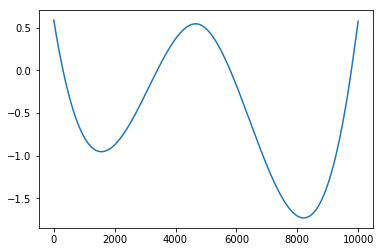

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()